In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

tqdm.pandas()
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-141-ge06a12b-dirty (engine: v0.7.0-140-gc2da156-dirty)
cpr_lib_version: v0.7.0-140-gc2da156-dirty


In [2]:
protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

## Run simulations

In [3]:
episodes = pd.read_pickle("experiments/rl-eval/episodes.pkl")
list(episodes.columns)

['protocol',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'batch',
 'learning_rate',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations']

# Find optimal policies

In [4]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

protocol  k    reward subblock_selection  alpha  gamma        kind  \
0           bk  8  constant                n/a    0.2   0.05  hard-coded   
1           bk  8  constant                n/a    0.2   0.05     trained   
2           bk  8  constant                n/a    0.2   0.05     trained   
3           bk  8  constant                n/a    0.2   0.50  hard-coded   
4           bk  8  constant                n/a    0.2   0.50     trained   
..         ... ..       ...                ...    ...    ...         ...   
247  tailstorm  8  discount          heuristic    0.5   0.50     trained   
248  tailstorm  8  discount          heuristic    0.5   0.50     trained   
249  tailstorm  8  discount          heuristic    0.5   0.95  hard-coded   
250  tailstorm  8  discount          heuristic    0.5   0.95     trained   
251  tailstorm  8  discount          heuristic    0.5   0.95     trained   

     reused             policy  
0     False             honest  
1     False  ppo-ub5mebn8-best  
2      True  ppo-pmrgklqq-best  
3     False             honest  
4     False  ppo-r73btgb2-best  
..      ...                ...  
247   False  ppo-ldgcu5sl-best  
248    True  ppo-2gamo0zy-best  
249   False        minor-delay  
250   False  ppo-ijtjbhmp-best  
251    True  ppo-jlwm4xoj-best  

[252 rows x 9 columns]

# Honest or Attack?

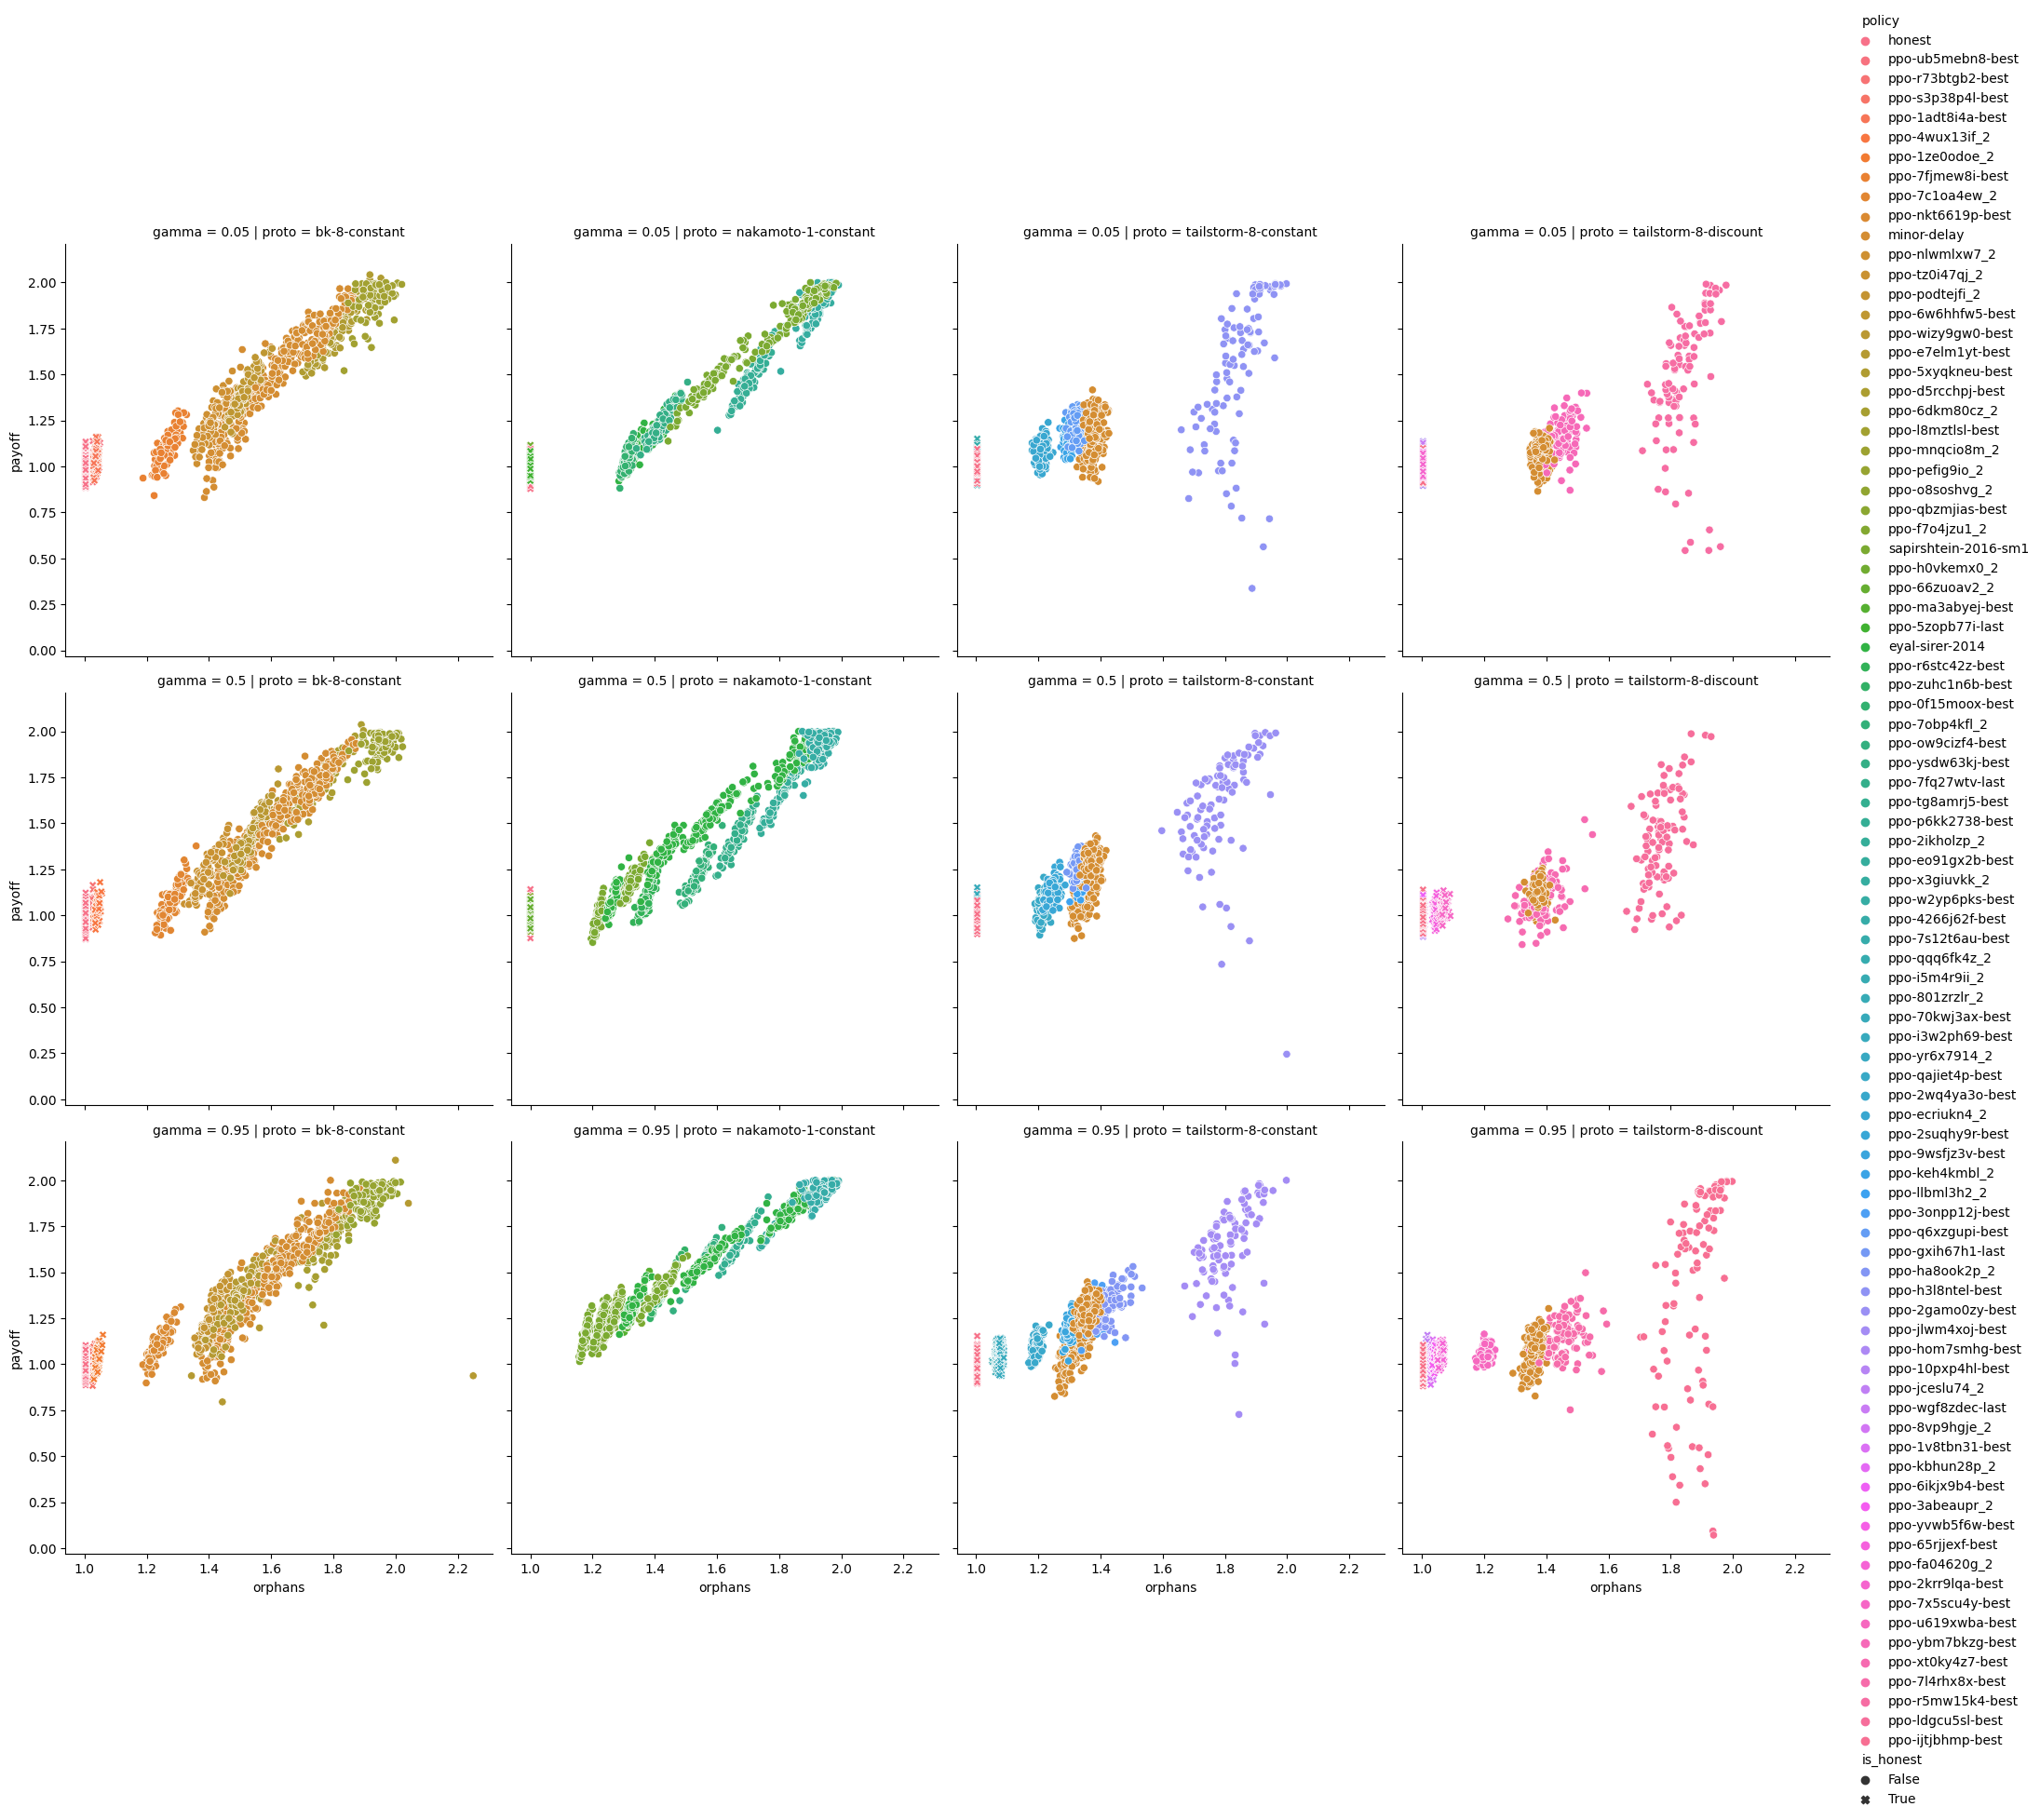

In [5]:
grouping = ["protocol", "k", "reward", "subblock_selection", "alpha", "gamma", "policy"]
d = opt_episodes.query("not reused")
d = d.assign(
    orphans=d.episode_n_activations / d.episode_progress,
    proto=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    payoff=d.episode_reward_attacker / d.episode_progress / d.alpha,
)
dd = d.groupby(grouping).agg(
    mean_orphans=("orphans", "mean"),
    mean_payoff=("payoff", "mean"),
    std_payoff=("payoff", "std"),
)
d = d.set_index(grouping + ["episode"]).join(dd).reset_index()
d = d.assign(is_honest=d.mean_orphans <= 1.15)
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="policy",
    style="is_honest",
    row="gamma",
    col="proto",
)
honest_or_attack_episodes = d  # for later use
# list(d.columns)

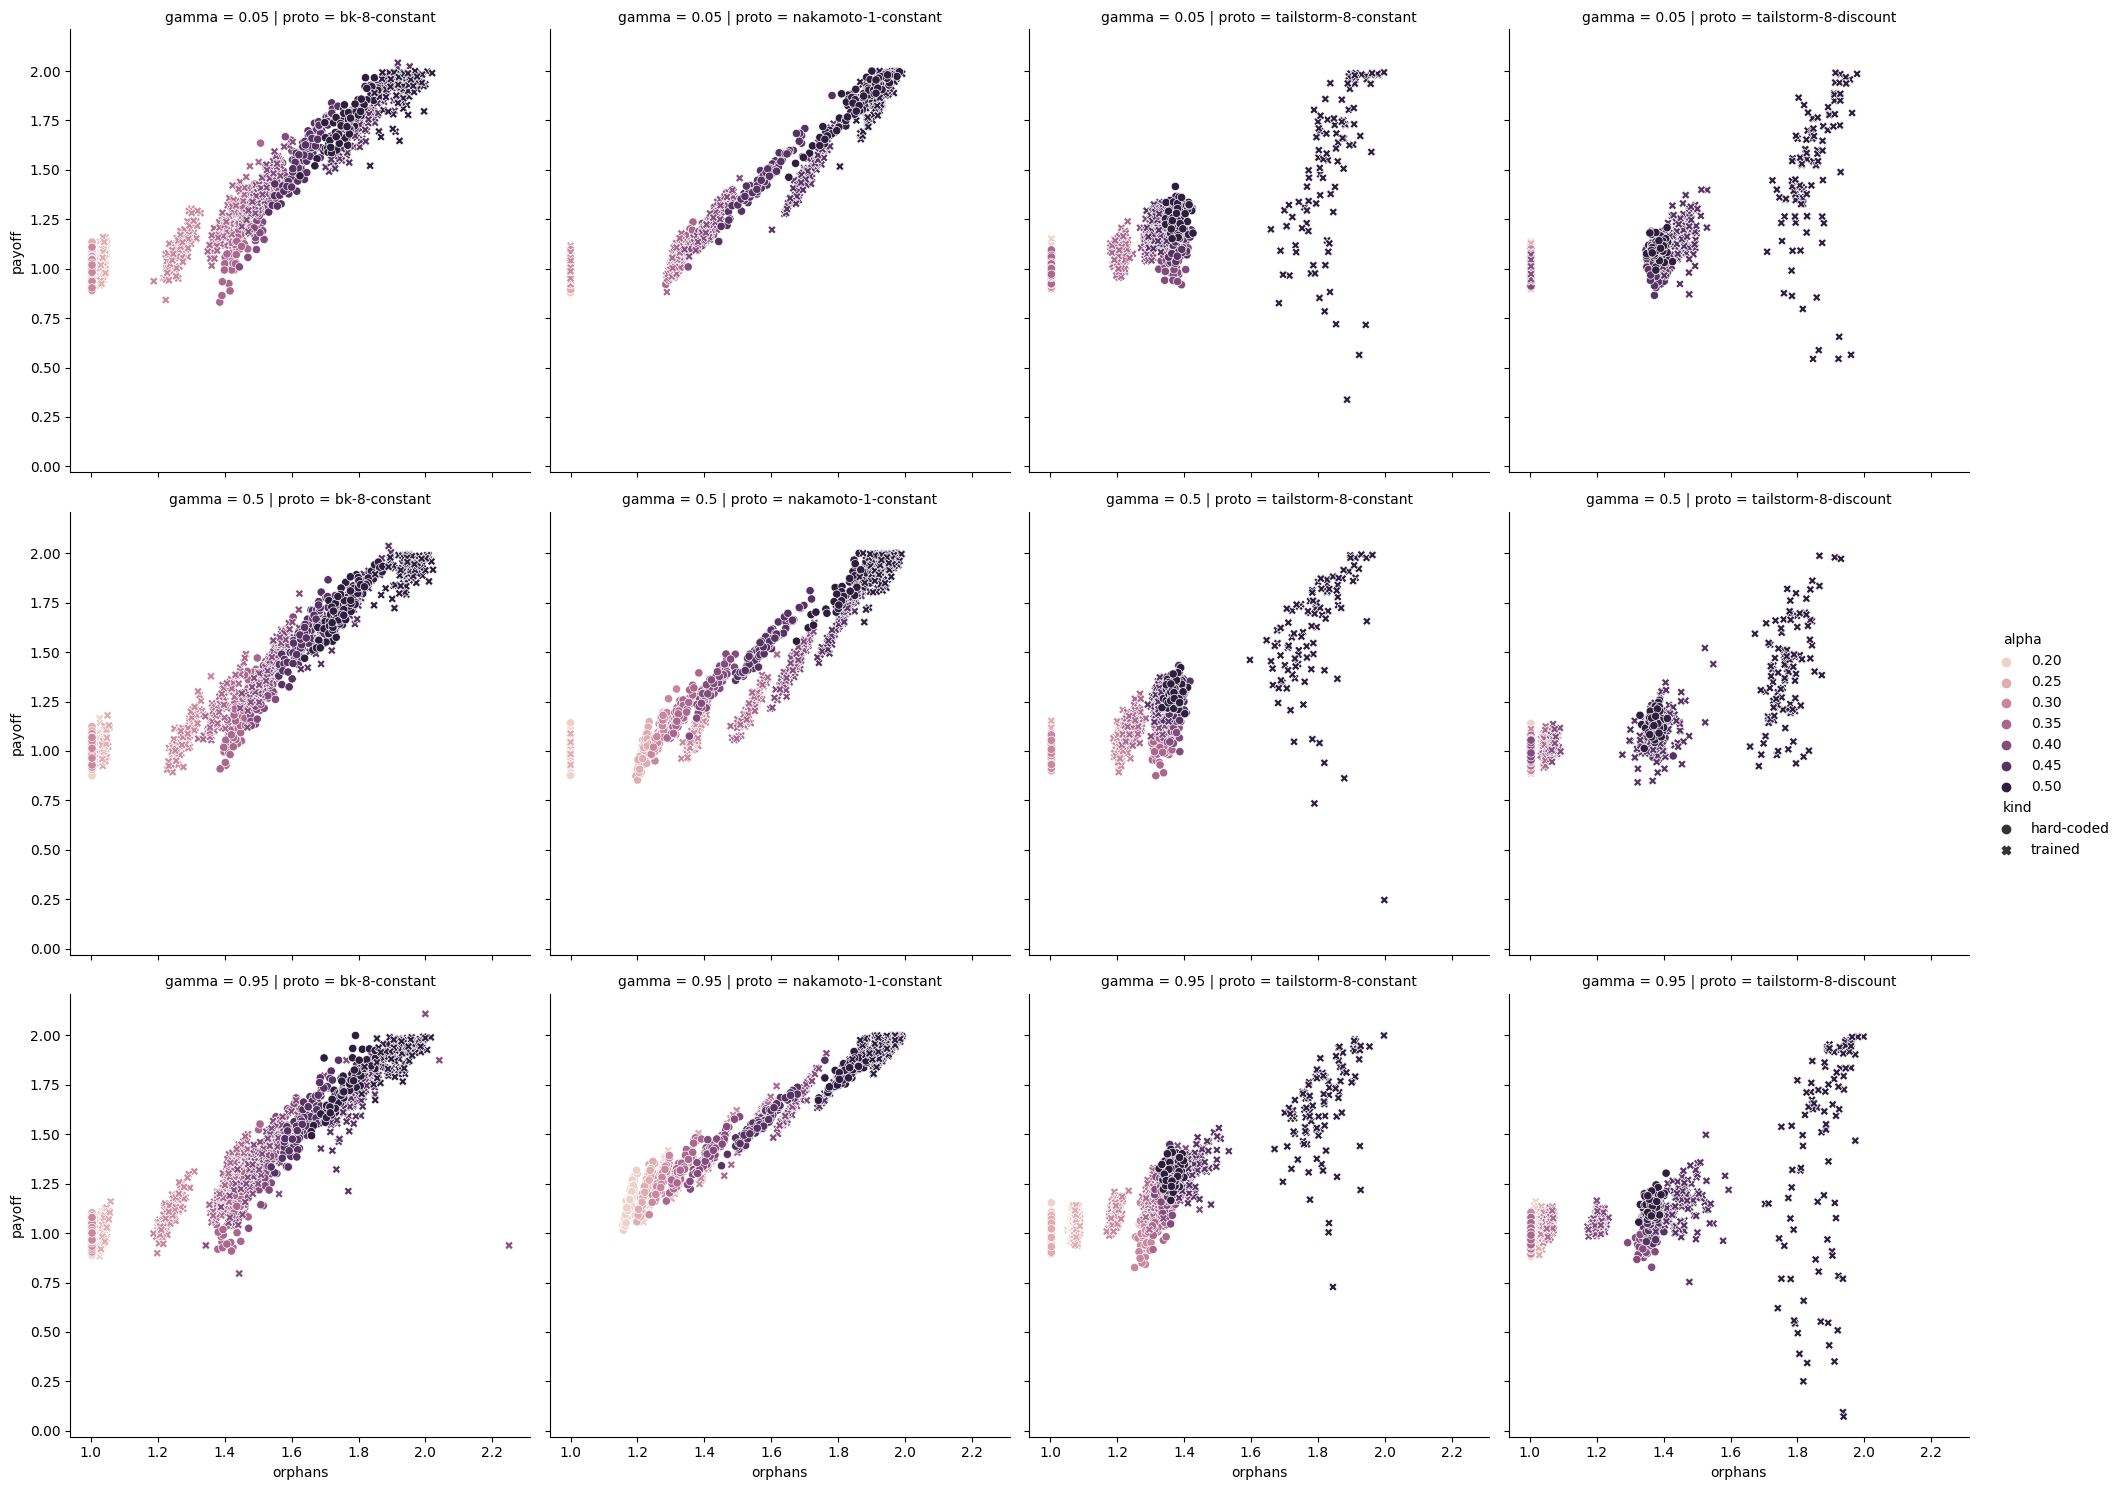

In [6]:
sns.relplot(
    data=d,
    x="orphans",
    y="payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

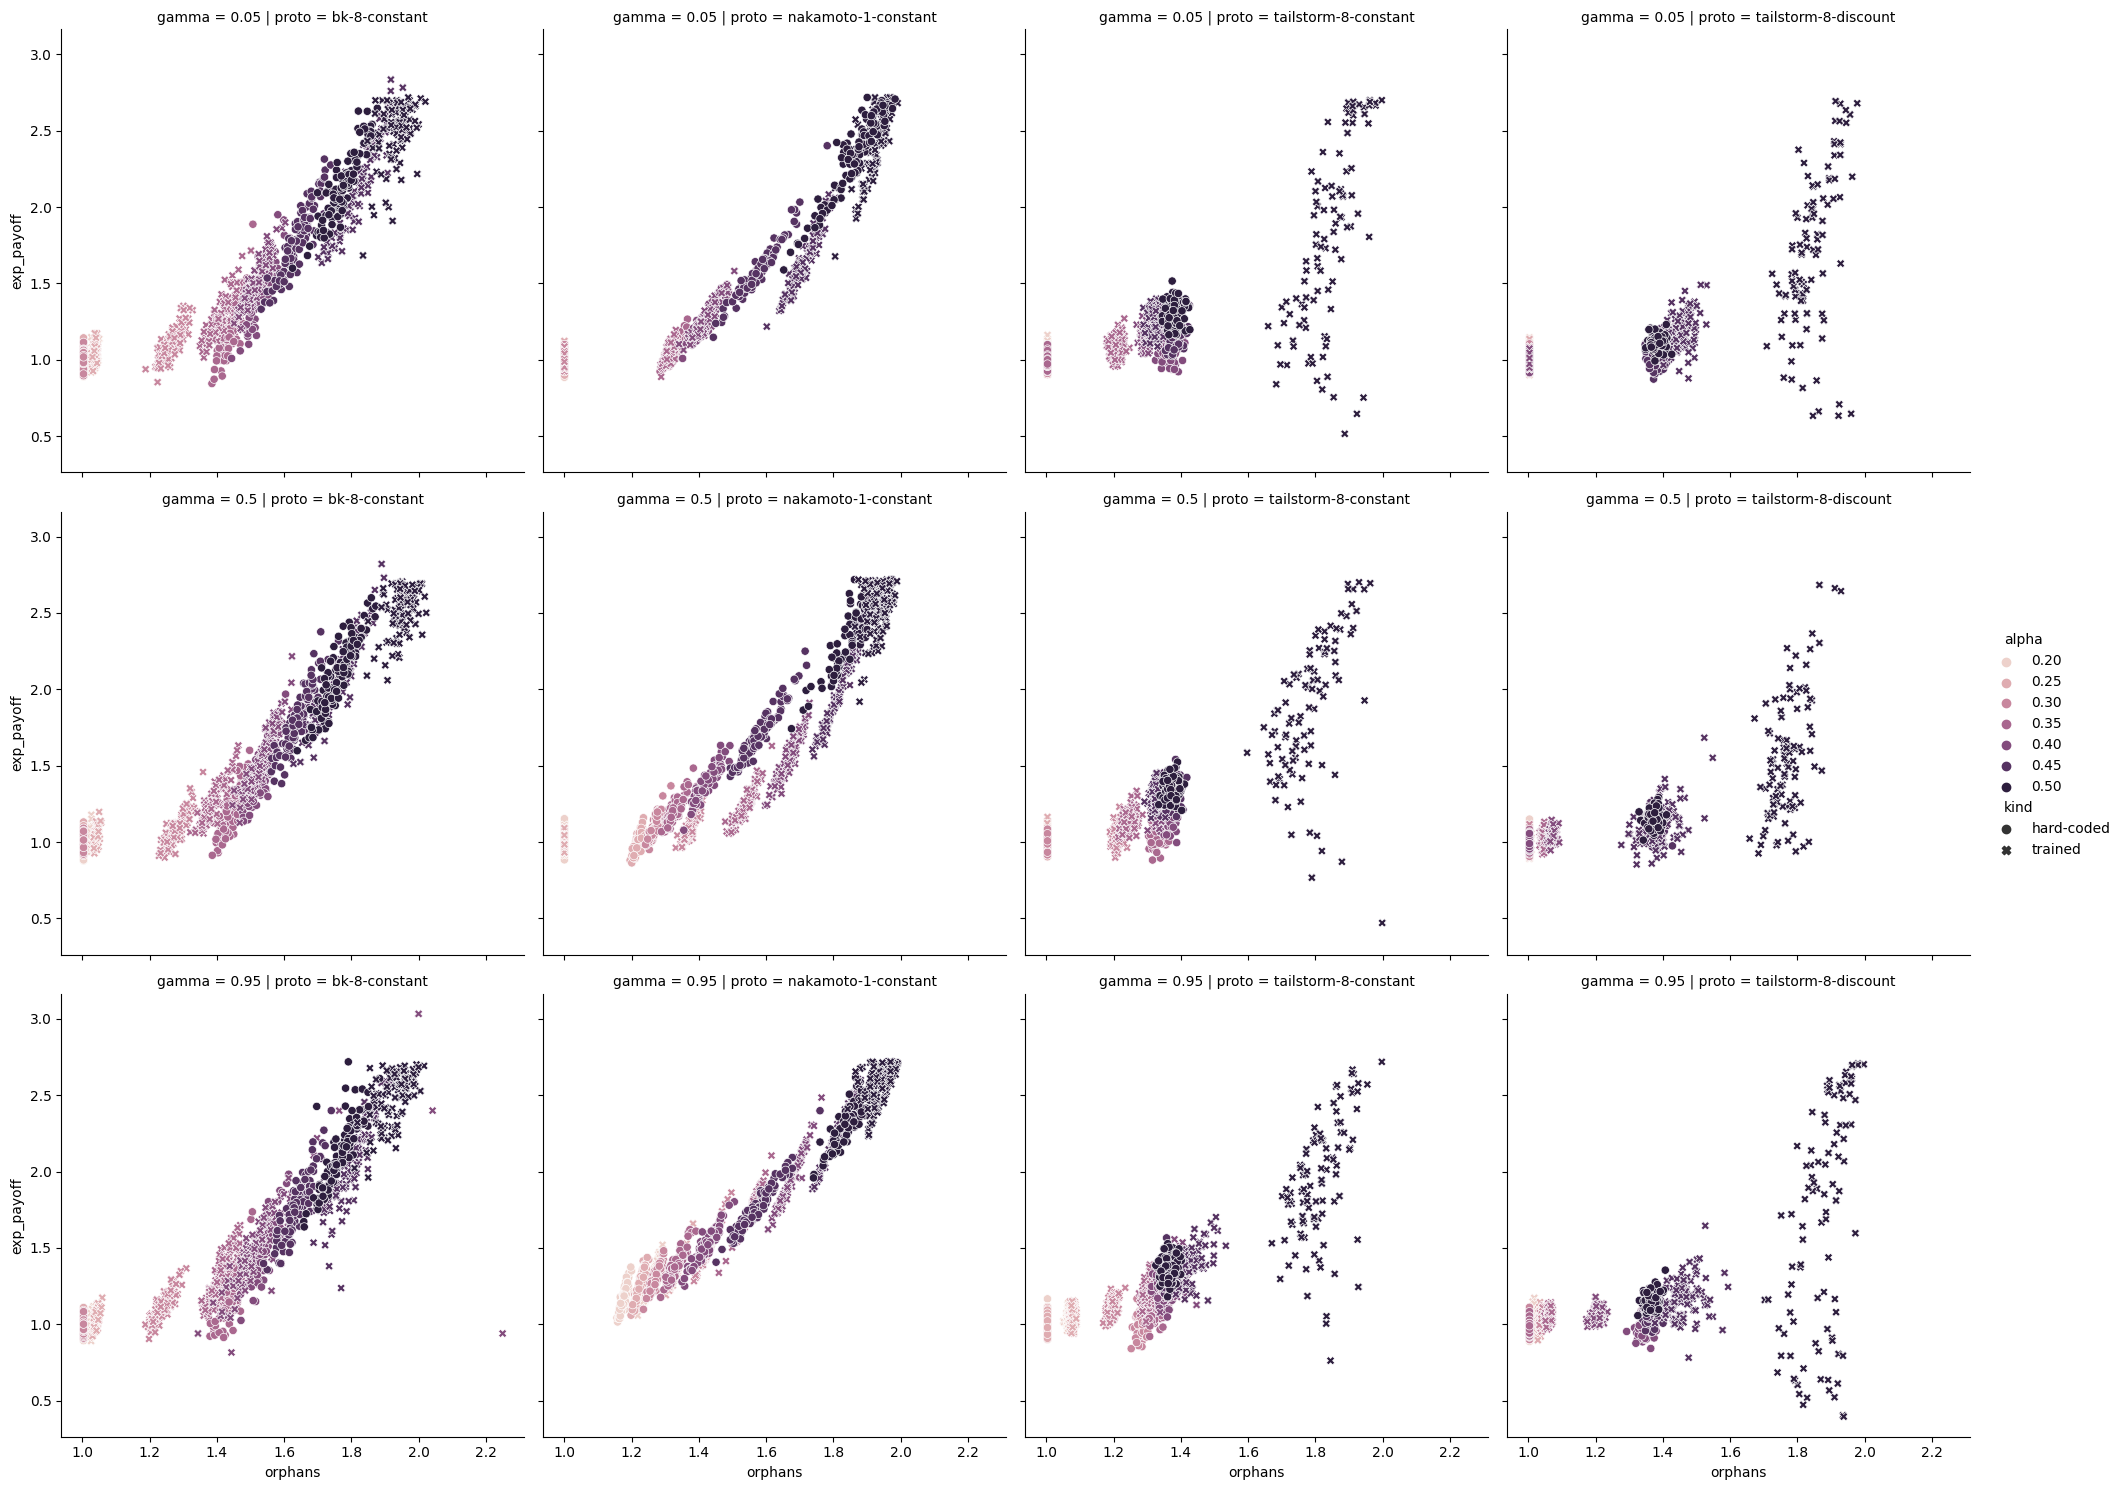

In [7]:
sns.relplot(
    data=d.assign(exp_payoff=np.exp(d.payoff - 1)),
    x="orphans",
    y="exp_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

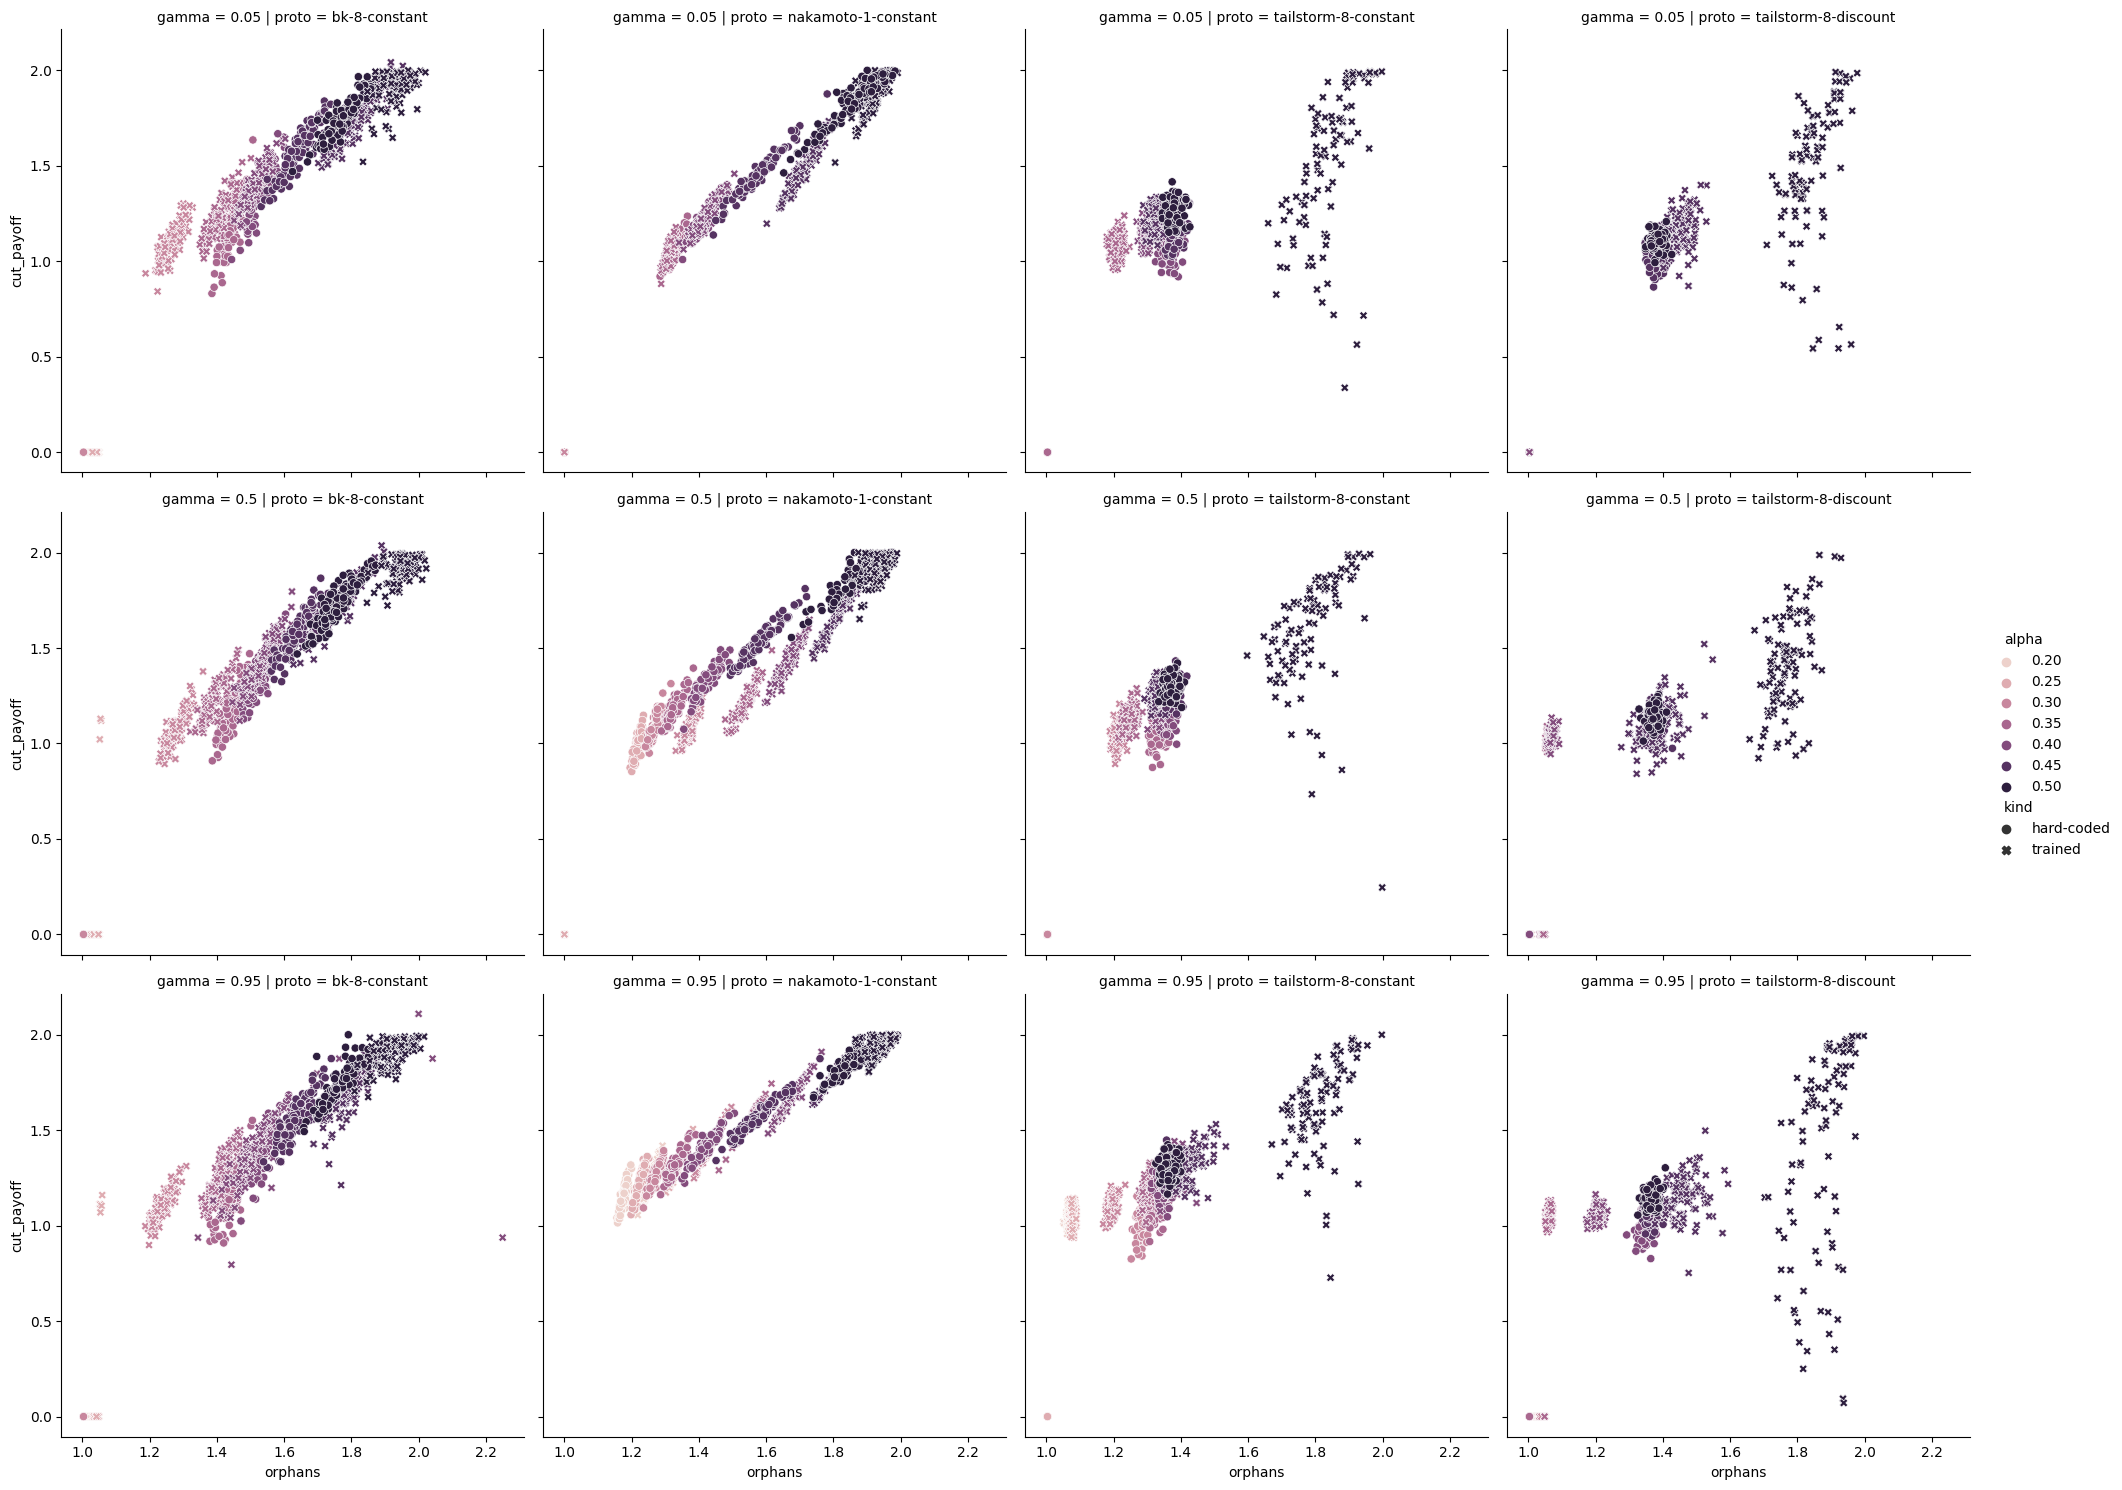

In [8]:
sns.relplot(
    data=d.assign(
        cut_payoff=[x.payoff if x.orphans > 1.05 else 0 for _, x in d.iterrows()]
    ),
    x="orphans",
    y="cut_payoff",
    hue="alpha",
    style="kind",
    row="gamma",
    col="proto",
)

# Break-even point

Per protocol and gamma, we proceed as follows:
1. grid-search the lowest relative hash rate $\hat{\alpha}$, where best policy $P$ produces some orphans
2. $P$ should be the first profitable policy after the break-even point
3. derive policy $P_\hat{\alpha}$ from $P$ by hard-wiring $\hat{\alpha}$ in the observation
4. evaluate $P_\hat{\alpha}$ on full range of alphas
    1. set loss funtcion `loss(alpha) = abs(reward_attacker / episode_progress / alpha - 1)`
    2. minimize loss function with Bayesian optimization

In [9]:
grouping = ["protocol", "k", "reward", "subblock_selection", "gamma", "kind"]
select = ["policy", "reused", "path"]
d = honest_or_attack_episodes.query("is_honest == False and reused==False")
d = d[grouping + ["alpha"] + select].drop_duplicates().reset_index(drop=True)
d = d.loc[d.groupby(grouping).alpha.idxmin()].reset_index(drop=True)
be_policies = d
display(be_policies.drop(columns="path"))

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.35   
1          bk  8  constant                n/a   0.05     trained   0.30   
2          bk  8  constant                n/a   0.50  hard-coded   0.35   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.35   
5          bk  8  constant                n/a   0.95     trained   0.30   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.35   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.30   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.40   

                  policy  reused  
0            minor-delay   False  
1      ppo-7fjmew8i-best   False  
2            minor-delay   False  
3         ppo-7c1oa4ew_2   False  
4            minor-delay   False  
5      ppo-nkt6619p-best   False  
6        eyal-sirer-2014   False  
7      ppo-0f15moox-best   False  
8   sapirshtein-2016-sm1   False  
9      ppo-r6stc42z-best   False  
10  sapirshtein-2016-sm1   False  
11        ppo-f7o4jzu1_2   False  
12           minor-delay   False  
13        ppo-ecriukn4_2   False  
14           minor-delay   False  
15     ppo-qajiet4p-best   False  
16           minor-delay   False  
17     ppo-2wq4ya3o-best   False  
18           minor-delay   False  
19     ppo-ybm7bkzg-best   False  
20           minor-delay   False  
21     ppo-xt0ky4z7-best   False  
22           minor-delay   False  
23     ppo-u619xwba-best   False

In [10]:
import break_even


def find_break_even_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = 8192  # quality of each point
    kwargs["n_calls"] = 100  # how many points
    kwargs["support"] = [0.05, 0.5]  # range of alphas
    kwargs[
        "title"
    ] = f"{x.protocol}({x.k}, {x.reward}, {x.subblock_selection})  γ={x.gamma}  {x.policy}"
    if x.kind == "trained":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore", category=UserWarning, lineno=458
            )  # transition to sb3 v1.7
            res = break_even.find_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = break_even.find_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


def parallel_measure(df, fun=find_break_even_row, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(fun)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


# d = be_policies.query("protocol == 'nakamoto'")
# d = be_policies.loc[[2]]

be_points = parallel_measure(be_policies, fun=find_break_even_row)

  0%|          | 0/24 [00:00<?, ?it/s]

In [11]:
# save episode data for re-use in other notebooks
be_points.to_pickle("experiments/rl-eval/be_points.pkl")

In [12]:
be_points.drop(columns=["path", "break_even_png"])

protocol  k    reward subblock_selection  gamma        kind  alpha  \
0          bk  8  constant                n/a   0.05  hard-coded   0.35   
1          bk  8  constant                n/a   0.05     trained   0.30   
2          bk  8  constant                n/a   0.50  hard-coded   0.35   
3          bk  8  constant                n/a   0.50     trained   0.30   
4          bk  8  constant                n/a   0.95  hard-coded   0.35   
5          bk  8  constant                n/a   0.95     trained   0.30   
6    nakamoto  1  constant                n/a   0.05  hard-coded   0.35   
7    nakamoto  1  constant                n/a   0.05     trained   0.35   
8    nakamoto  1  constant                n/a   0.50  hard-coded   0.25   
9    nakamoto  1  constant                n/a   0.50     trained   0.30   
10   nakamoto  1  constant                n/a   0.95  hard-coded   0.20   
11   nakamoto  1  constant                n/a   0.95     trained   0.20   
12  tailstorm  8  constant          heuristic   0.05  hard-coded   0.40   
13  tailstorm  8  constant          heuristic   0.05     trained   0.35   
14  tailstorm  8  constant          heuristic   0.50  hard-coded   0.35   
15  tailstorm  8  constant          heuristic   0.50     trained   0.30   
16  tailstorm  8  constant          heuristic   0.95  hard-coded   0.30   
17  tailstorm  8  constant          heuristic   0.95     trained   0.30   
18  tailstorm  8  discount          heuristic   0.05  hard-coded   0.45   
19  tailstorm  8  discount          heuristic   0.05     trained   0.45   
20  tailstorm  8  discount          heuristic   0.50  hard-coded   0.45   
21  tailstorm  8  discount          heuristic   0.50     trained   0.45   
22  tailstorm  8  discount          heuristic   0.95  hard-coded   0.40   
23  tailstorm  8  discount          heuristic   0.95     trained   0.40   

                  policy  reused  break_even  
0            minor-delay   False    0.308214  
1      ppo-7fjmew8i-best   False    0.249461  
2            minor-delay   False    0.309863  
3         ppo-7c1oa4ew_2   False    0.268724  
4            minor-delay   False    0.311140  
5      ppo-nkt6619p-best   False    0.224963  
6        eyal-sirer-2014   False    0.326297  
7      ppo-0f15moox-best   False    0.333240  
8   sapirshtein-2016-sm1   False    0.248218  
9      ppo-r6stc42z-best   False    0.268123  
10  sapirshtein-2016-sm1   False    0.082473  
11        ppo-f7o4jzu1_2   False    0.050000  
12           minor-delay   False    0.371008  
13        ppo-ecriukn4_2   False    0.297031  
14           minor-delay   False    0.324255  
15     ppo-qajiet4p-best   False    0.254122  
16           minor-delay   False    0.280548  
17     ppo-2wq4ya3o-best   False    0.202687  
18           minor-delay   False    0.437024  
19     ppo-ybm7bkzg-best   False    0.402255  
20           minor-delay   False    0.417055  
21     ppo-xt0ky4z7-best   False    0.398009  
22           minor-delay   False    0.399474  
23     ppo-u619xwba-best   False    0.327535

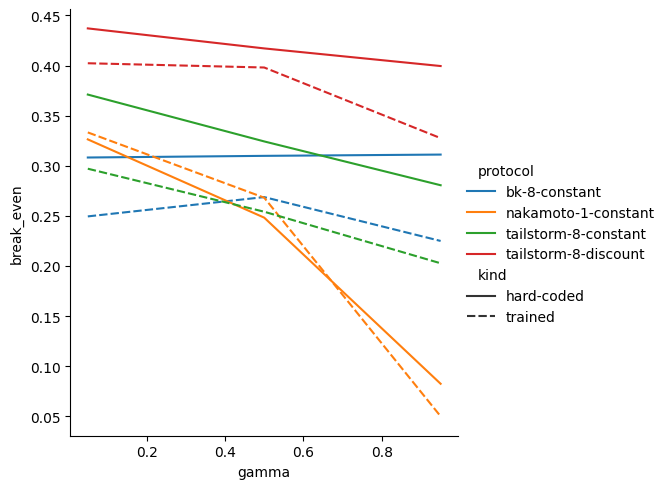

In [13]:
d = be_points.copy()
d.loc[d.reused, "kind"] = "trained/reused"
sns.relplot(
    data=d.assign(
        protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
    ),
    kind="line",
    hue="protocol",
    x="gamma",
    y="break_even",
    style="kind",
)

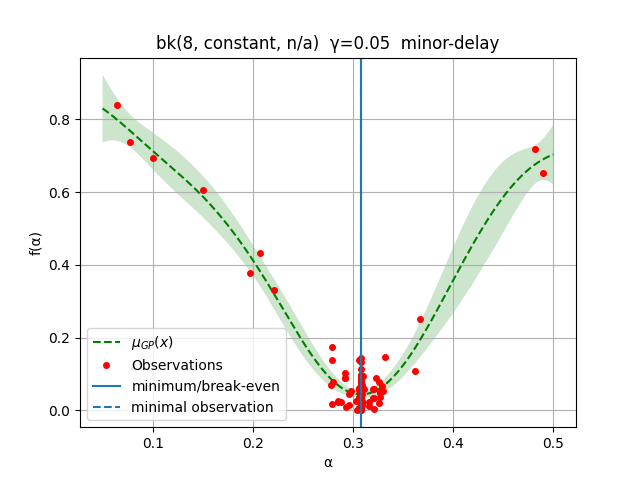

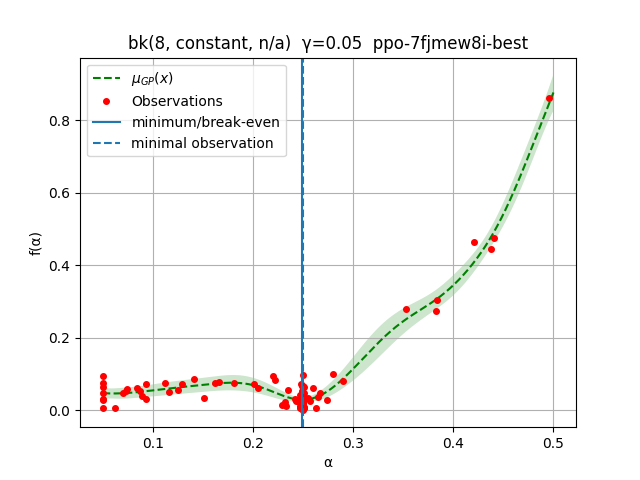

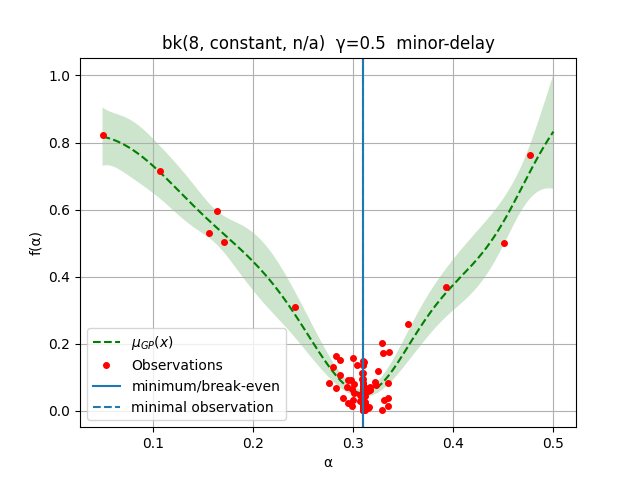

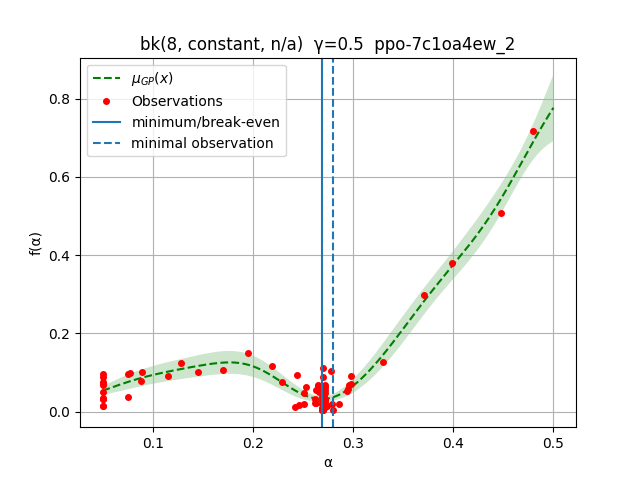

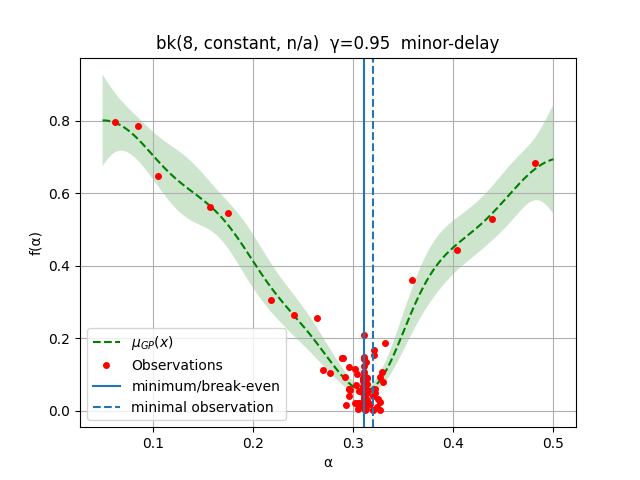

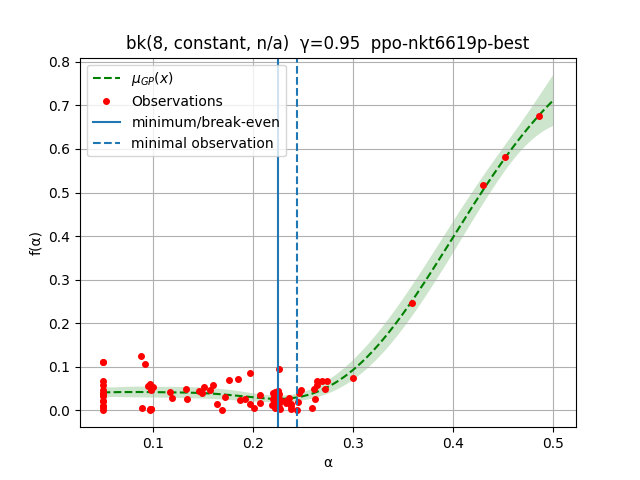

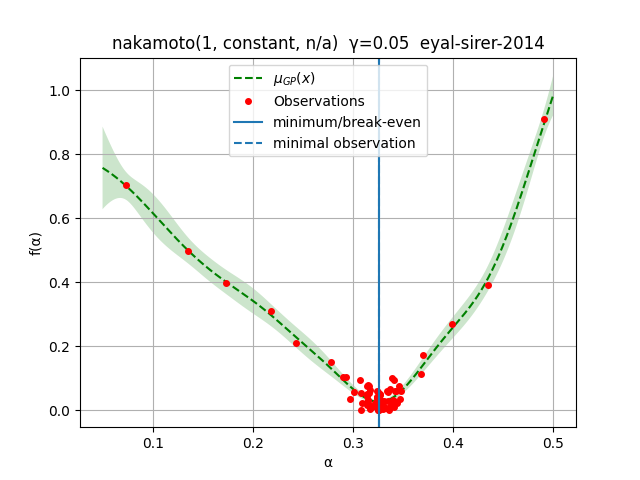

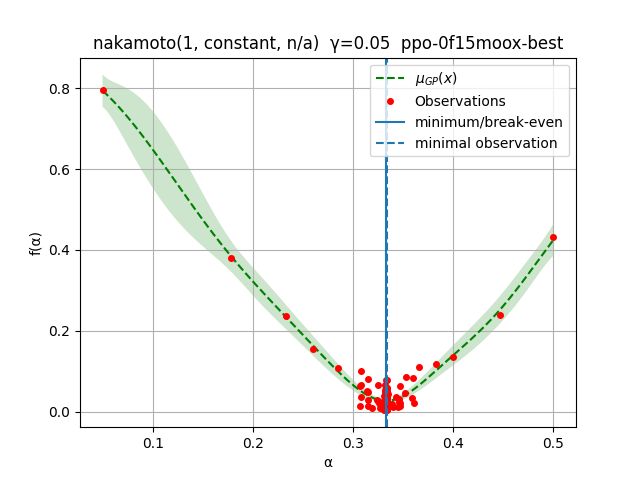

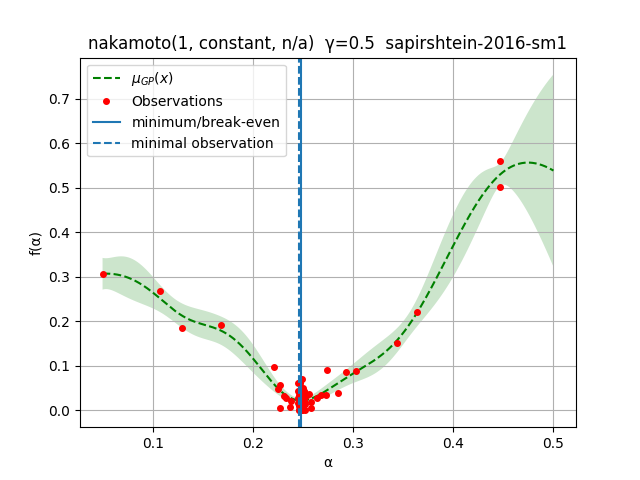

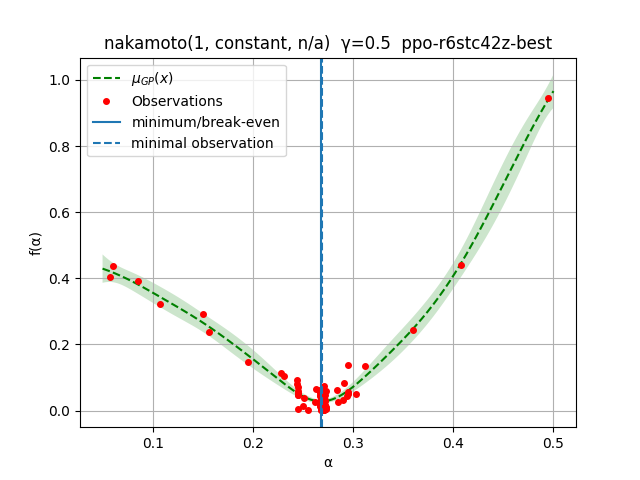

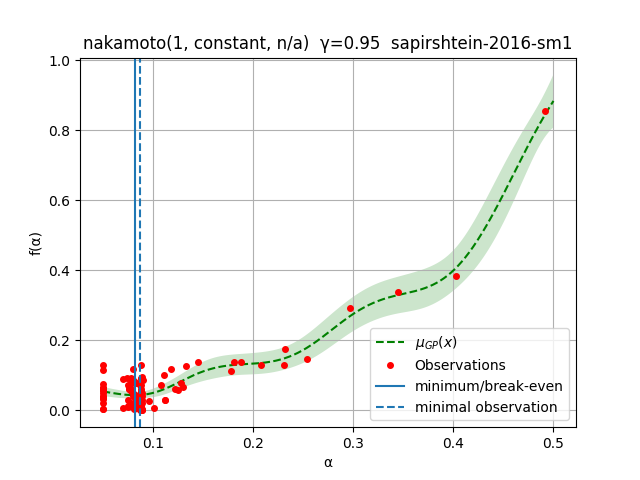

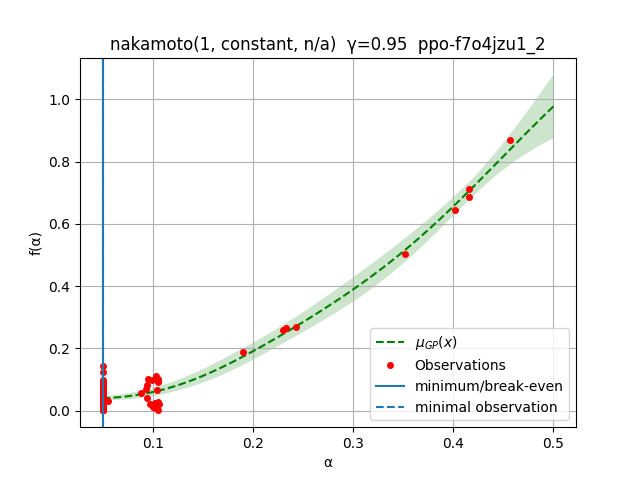

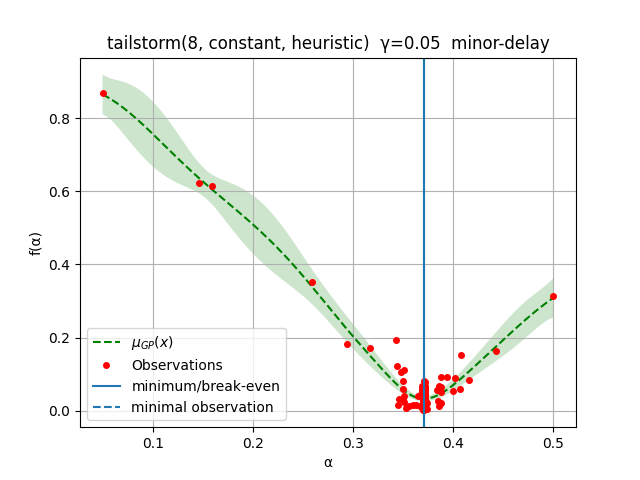

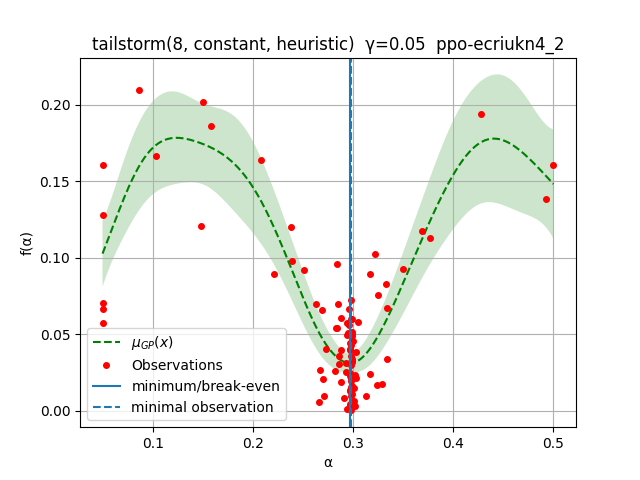

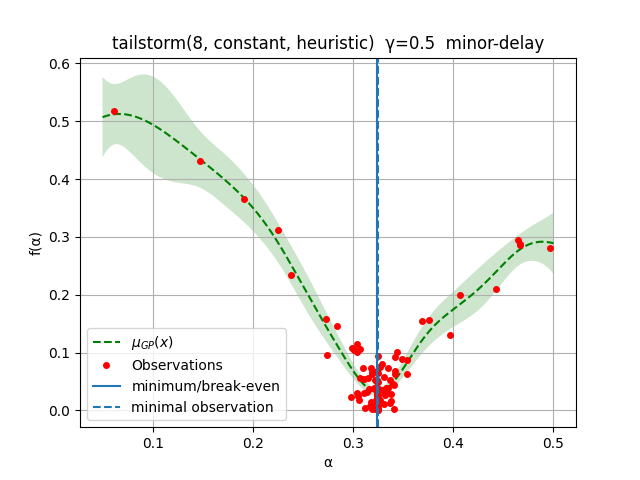

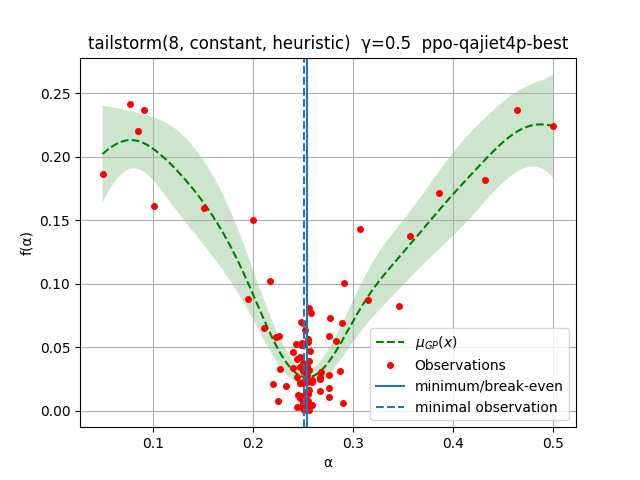

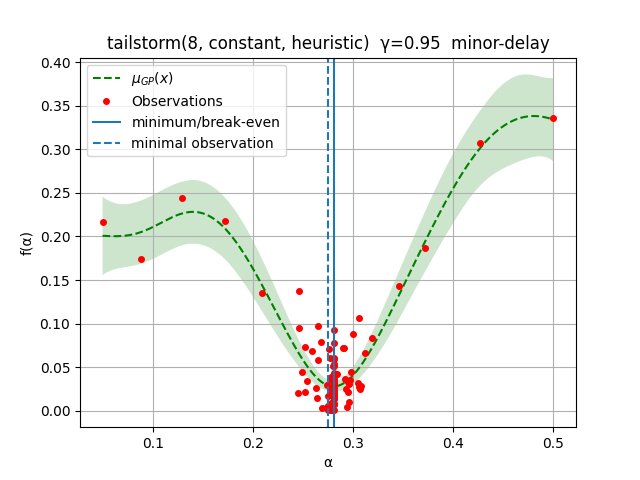

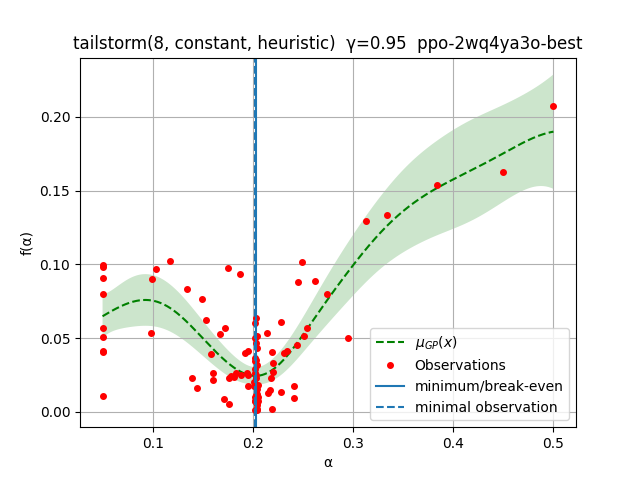

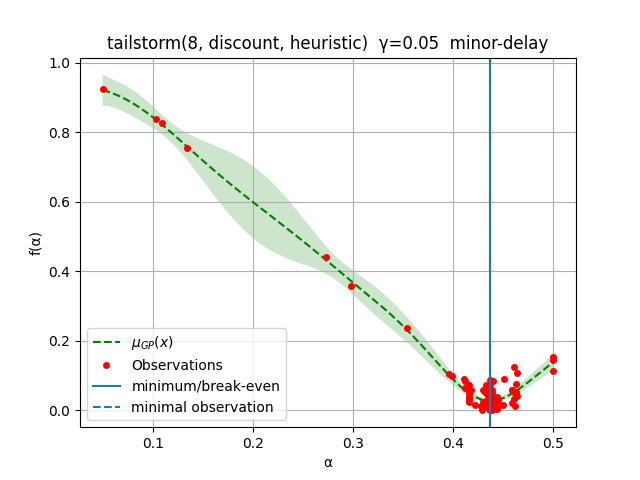

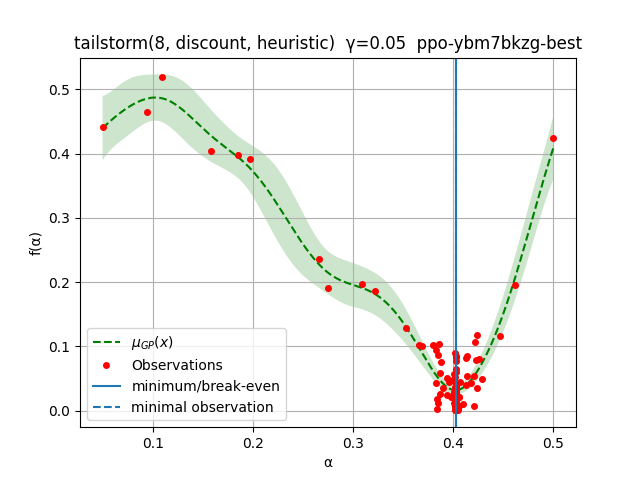

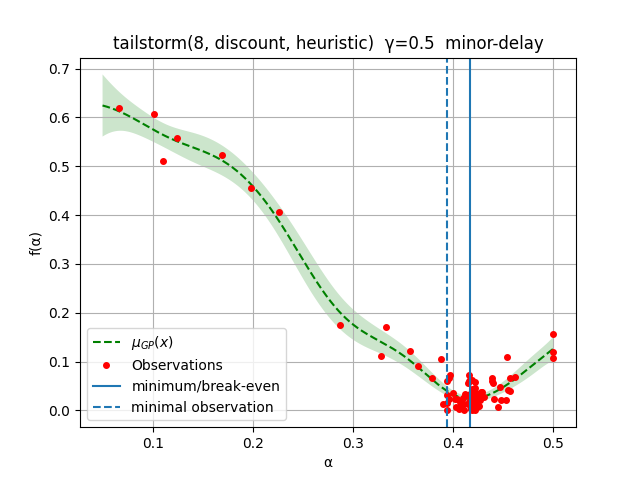

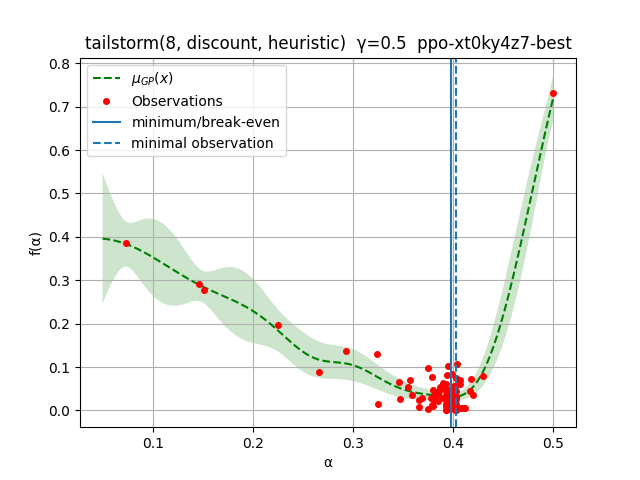

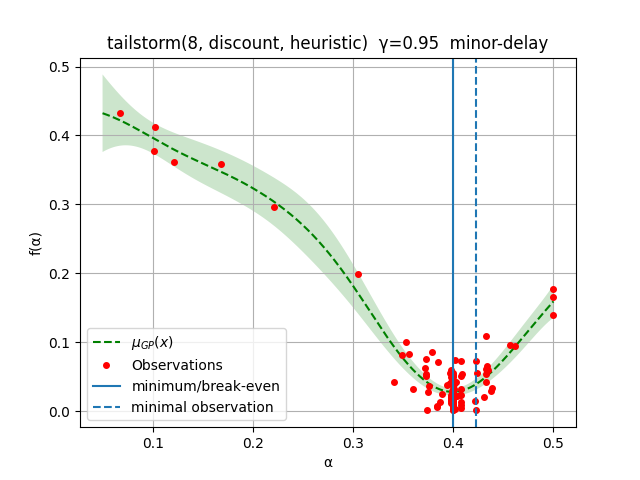

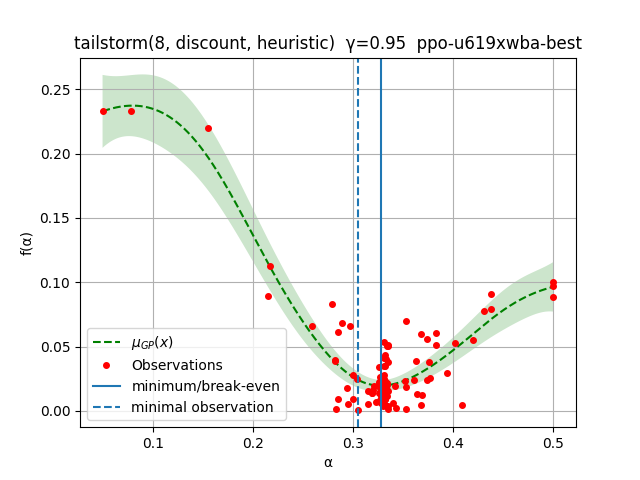

In [14]:
import IPython.display

_ = be_points.break_even_png.apply(
    lambda x: display(IPython.display.Image(data=x, format="png"))
)